# Assignment 2
## ✅ Rename the filename with your roll number. E.g. if your roll number is `MT24003` then rename the file `MT24003_a2.ipynb`.
## ✅ Write code only in the sections marked with `# YOUR CODE HERE`. No, you can NOT write code anywhere else.
## ✅ Download and extract the `data.zip` folder next to this file. If you extract it correctly, you will have a `data` folder next to this file.
## ✅ Submit a .zip (NOT .tar, .rar, etc) file containining:
###    1. This Notebook after filling the code where asked.
###    2. The loss and metric plots generated using the `save_training_report` functions [`auto_encoder.png` + `variational_auto_encoder.png` + `conditional_variational_auto_encoder.png`].
###    3. The model weights saved using the  `save_model_weights` functions [`auto_encoder.pth` + `variational_auto_encoder.pth` + `conditional_variational_auto_encoder.pth`].
## ❌ Do not modify any other function or class definitions; doing so may lead to the autograder failing to judge your submission, resulting in a zero.
## ❌ Deleting or adding new cells may lead to the `autograder` failing to judge your submission, resulting in a zero. Even if a cell is empty, do NOT delete it.
## ❌ Do NOT install / import any other libraries. You should be able to solve all the questions using only the libraries imported below.

In [1]:
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 -q
!pip install numpy==1.25.2 -q
!pip install soundfile==0.13.0 -q
!pip install pandas==2.2.3 -q
!pip install matplotlib==3.9.4 -q
!pip install scikit-image==0.21.0 -q
!pip install tqdm==4.67.1 -q


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import random
import timeit
from pathlib import Path
from typing import Tuple
from skimage.metrics import structural_similarity as ssim
from numpy import array as NumpyArray
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from tqdm import tqdm

In [3]:
PATH_TO_DATA_DIR = Path("./data")
PATH_TO_TRAIN_DATA_DIR = str(PATH_TO_DATA_DIR / "train")
PATH_TO_TEST_DATA_DIR = str(PATH_TO_DATA_DIR / "test")

# `q1`: `FashionMNIST` Dataset
1. Implement a Dataset class for the `FashionMNIST` data for the task of `Image Restoration`.
2. The task of `Image Restoration` is an [Ill-posed problem](https://en.wikipedia.org/wiki/Well-posed_problem) where the goal is to restore the original image from a corrupted image. Thus there may be more than one augmented image for each clean image, and vice versa.
3. The `data` directory has the following directory structure:
4. ```
	data
    ├── train
    │   ├── aug
    │   │   ├── <imagenumber>_<classlabel>.png
    │   │   ├── ...
    │   ├── clean
    │   │   ├── <imagenumber>_<classlabel>.png
    │   │   ├── ...
    └── test
        ├── aug
        │   ├── <imagenumber>_<classlabel>.png
        │   ├── ...
        └── clean
            ├── <imagenumber>_<classlabel>.png
            ├── ...
    ```
5. Constraints:
   1. The `__getitem__` method should return a tuple of the form `(aug_image, clean_image, label)`.  `clean_image` is the clean image, `aug_image` is the augmented image, and `label` is the class label of the image.
   2. Both `clean_image` and `aug_image` tensors should be of the shape `(1, 28, 28)` and of type `torch.float32`.
   3. Both `clean_image` and `aug_image` tensors should have pixel values between `[0, 1]`.
   4. `label` should be of type `torch.int64`.


`q1` Grading [Total: 1]: `1` point if the code runs without any errors on hidden test cases, otherwise `0` points. No partial points for this question.

In [4]:
class FashionMNISTDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset for loading paired FashionMNIST images (augmented and clean versions).

    Attributes:
        augmented_images (List[str]): List of file paths to augmented images, sorted alphabetically.
        clean_images (List[str]): List of file paths to clean images, sorted alphabetically.
    """
    def __init__(
        self, path_to_augmented_images_dir: str, path_to_clean_images_dir: str
    ):
        """
        Initializes the dataset by loading file paths for augmented and clean images.

        Args:
            path_to_augmented_images_dir (str): Path to the directory containing augmented images.
            path_to_clean_images_dir (str): Path to the directory containing clean images.
        """
        # YOUR CODE HERE
        self.augmented_list = []
        self.clean_list = []

        for i in os.listdir(path_to_augmented_images_dir):
          self.augmented_list.append(os.path.join(path_to_augmented_images_dir, i))

        for i in os.listdir(path_to_clean_images_dir):
          self.clean_list.append(os.path.join(path_to_clean_images_dir, i))



    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.

        Returns:
            int
        """
        # YOUR CODE HERE
        return len(self.augmented_list)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Retrieves the augmented image, clean image, and label for a given index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
                - Augmented image as a tensor with values normalized to [0, 1].
                - Clean image as a tensor with values normalized to [0, 1].
                - Label as an integer tensor, extracted from the filename.
        """
        # YOUR CODE HERE
        aug = self.augmented_list[idx]
        clean = self.clean_list[idx]

        augmented_image = torchvision.io.read_image(aug).float() / 255.0
        clean_image = torchvision.io.read_image(clean).float() / 255.0

        label = int((os.path.basename(aug).split("_")[1]).split(".")[0])
        label = torch.tensor(label, dtype=torch.int64)

        return augmented_image, clean_image, label



In [5]:
# tests for q1

path_to_train_images_aug_dir = str(PATH_TO_TRAIN_DATA_DIR + "/aug")
path_to_train_images_clean_dir = str(PATH_TO_TRAIN_DATA_DIR + "/clean")
fashion_mnist_dataset = FashionMNISTDataset(
    path_to_augmented_images_dir=path_to_train_images_aug_dir,
    path_to_clean_images_dir=path_to_train_images_clean_dir,
)


In [6]:
# tests for q1

path_to_test_images_aug_dir = str(PATH_TO_TEST_DATA_DIR + "/aug")
path_to_test_images_clean_dir = str(PATH_TO_TEST_DATA_DIR + "/clean")
fashion_mnist_dataset = FashionMNISTDataset(
    path_to_augmented_images_dir=path_to_test_images_aug_dir,
    path_to_clean_images_dir=path_to_test_images_clean_dir,
)


del fashion_mnist_dataset

# `q2`: Encoder, and Decoder classes

* Your task is to create AutoEncoder models for the task of `Image Restoration` using the `FashionMNIST` dataset. You need to implement the `Encoder` and `Decoder` classes for the AutoEncoder model. The `Encoder` class will be used to encode the input image into a latent representation, and the `Decoder` class will be used to decode the latent representation back to the original image. The `Encoder` and `Decoder` classes will be used in the AutoEncoder model, Variational AutoEncoder model, and (optionally) Conditional AutoEncoder model, so the implementation should be **generic and not specific** to any of the models.
* `q2a`: `Encoder` class: Implement a generic Encoder Module that will be used within all the AutoEncoder flavors (AutoEncoder, Variational AutoEncoder, and (optinally) Conditional AutoEncoder). Constraints:
  1. The input tensor will be of shape `[batch_size, 1, 28, 28]` that comes out of the DataLoader of the `FashionMNIST` dataset.
  2. Feel free to use any architecture you like with any layer or activation function in it. **You can NOT use pre-trained model weights**.
  3. The output tensor must be of shape `[batch_size, output_channels, height, width]`. This tensor will be the latent representation of the input tensor and will be passed to the Decoder Module.
  4. The number of parameters in the Encoder Module must be between 2,000 and 1,000,000 (both inclusive). Note that the number of parameters in the Encoder Module and Decoder Module will be counted separately and may not be the same.

* `q2b`: `Decoder` class: Implement a generic Decoder Module that will be used within all the AutoEncoder flavors (AutoEncoder, Variational AutoEncoder, and (optinally) Conditional AutoEncoder). Constraints:
  1. The input tensor will be of shape `[batch_size, input_channels, height, width]` that comes out of the Encoder Module.
  2. Feel free to use any architecture you like with any layer or activation function in it. **You can NOT use pre-trained model weights**.
  3. The output tensor must be of shape `[batch_size, 1, 28, 28]`. This tensor will be the reconstructed image of the input tensor.
  4. The number of parameters in the Decoder Module must be between 2,000 and 1,000,000 (both inclusive). Note that the number of parameters in the Encoder Module and Decoder Module will be counted separately and may not be the same.

`q2` Grading [Total: 2 points]:
1. `q2a`: `Encoder` class: `0.25` points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
2. `q2b`: `Decoder` class:  `0.25` points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.

## `q2a`: `Encoder` class

In [139]:
class Encoder(torch.nn.Module):
    def __init__(self, output_channels: int, type_of_autoencoder: str = None):
        super(Encoder, self).__init__()

        
        self.l1 = torch.nn.Conv2d(1, 8, kernel_size=3, padding=1)  
        self.batch1 = torch.nn.BatchNorm2d(8)

        self.l2 = torch.nn.Conv2d(8, 20, kernel_size=3, padding=1)
        self.batch2 = torch.nn.BatchNorm2d(20)

        self.l3 = torch.nn.Conv2d(20, 50, kernel_size=3, padding=1)  
        self.batch3 = torch.nn.BatchNorm2d(50)

        self.l4 = torch.nn.Conv2d(50, 80, kernel_size=3, padding=1)  
        self.batch4 = torch.nn.BatchNorm2d(80)

        self.l5 = torch.nn.Conv2d(80, 100, kernel_size=3, padding=1)  
        self.batch5 = torch.nn.BatchNorm2d(100)

        self.l6 = torch.nn.Conv2d(100, 150, kernel_size=3, padding=1, stride=2)  
        self.batch6 = torch.nn.BatchNorm2d(150)

        self.l7 = torch.nn.Conv2d(150, 256, kernel_size=3, padding=1, stride=2)  
        self.batch7 = torch.nn.BatchNorm2d(256)

        self.l8 = torch.nn.Conv2d(256, output_channels, kernel_size=3, padding=1, stride=2)  

        self.relu = torch.nn.SiLU()
        self.flatten = torch.nn.Flatten()
        self.dropout1 = torch.nn.Dropout(0.1)
        self.dropout2 = torch.nn.Dropout(0.25)
        self.fc = torch.nn.Linear(output_channels * 4 * 4, output_channels)

    def forward(self, x):
        x1 = self.relu(self.batch1(self.l1(x)))  
        x2 = self.relu(self.batch2(self.l2(x1)))  
        x3 = self.dropout1(self.relu(self.batch3(self.l3(x2))))
        x4 = self.dropout1(self.relu(self.batch4(self.l4(x3))))  
        x5 = self.dropout2(self.relu(self.batch5(self.l5(x4))))  
        x6 = self.dropout2(self.relu(self.batch6(self.l6(x5))))  
        x7 = self.dropout2(self.relu(self.batch7(self.l7(x6))))  
        x8 = self.relu(self.l8(x7))  

        x8_flat = self.flatten(x8)  
        latent = self.fc(x8_flat)  

        return latent, [x1, x2, x3, x4, x5, x6, x7]


In [8]:
# tests for q2a

encoder = Encoder(output_channels=64, type_of_autoencoder="vae")

random_input_tensor = torch.randn(1, 1, 28, 28)
output_tensor = encoder(random_input_tensor)


del encoder

## `q2b`: `Decoder` class

In [140]:
class Decoder(torch.nn.Module):
    def __init__(self, input_channels: int, type_of_autoencoder: str):
        super(Decoder, self).__init__()

    
        self.fc = torch.nn.Linear(input_channels, input_channels * 4 * 4)

        self.input_c = input_channels
        self.type = type_of_autoencoder

        self.deconv1 = torch.nn.ConvTranspose2d(input_channels, 256, kernel_size=3, padding=1, stride=2, output_padding=0)  
        self.batch1 = torch.nn.BatchNorm2d(256)

        self.deconv2 = torch.nn.ConvTranspose2d(256, 150, kernel_size=3, padding=1, stride=2, output_padding=1)  
        self.batch2 = torch.nn.BatchNorm2d(150)

        self.deconv3 = torch.nn.ConvTranspose2d(150, 100, kernel_size=3, padding=1, stride=2, output_padding=1)  
        self.batch3 = torch.nn.BatchNorm2d(100)

        self.deconv4 = torch.nn.ConvTranspose2d(100, 80, kernel_size=3, padding=1, stride=1)  
        self.batch4 = torch.nn.BatchNorm2d(80)

        self.deconv5 = torch.nn.ConvTranspose2d(80, 50, kernel_size=3, padding=1, stride=1)  
        self.batch5 = torch.nn.BatchNorm2d(50)

        self.deconv6 = torch.nn.ConvTranspose2d(50, 20, kernel_size=3, padding=1, stride=1)  
        self.batch6 = torch.nn.BatchNorm2d(20)


        self.deconv7 = torch.nn.ConvTranspose2d(20, 8, kernel_size=3, padding=1, stride=1)  
        self.batch7 = torch.nn.BatchNorm2d(8)

        self.deconv8 = torch.nn.ConvTranspose2d(8, 1, kernel_size=3, padding=1, stride=1)

        self.relu = torch.nn.SiLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, x, condition=None, skip_connections=None):
        

        if x.ndim == 4:
            pass
        elif x.ndim == 2:
            x = self.fc(x)
            x = x.view(-1, self.input_c, 4, 4)
            
        x = self.dropout(self.relu(self.batch1(self.deconv1(x)))) + skip_connections[6]  
        x = self.relu(self.batch2(self.deconv2(x))) + skip_connections[5]  
        x = self.relu(self.batch3(self.deconv3(x))) + skip_connections[4]  
        x = self.relu(self.batch4(self.deconv4(x))) #+ skip_connections[3]  
        x = self.relu(self.batch5(self.deconv5(x))) #+ skip_connections[2]  
        x = self.relu(self.batch6(self.deconv6(x))) #+ skip_connections[1]  
        x = self.relu(self.batch7(self.deconv7(x))) #+ skip_connections[0]  


        x = self.sigmoid(self.deconv8(x))  

        return x


In [10]:
# tests for q2b

decoder = Decoder(input_channels=64, type_of_autoencoder="vae")

random_input_tensor = torch.randn(1, 64, 4, 4)
output_tensor = decoder(random_input_tensor)


del decoder

# `q3`: AutoEncoder Model
* `q3a`: `AutoEncoder` class: Implement a AutoEncoder that uses the Encoder and Decoder Modules implemented in `q2a` and `q2b`. Constraints:
  1. The number of parameters in the AutoEncoder must be between 4,000 and 2,000,000 (both inclusive).
  2. The input tensor will be of shape `[batch_size, 1, 28, 28]` that comes out of the DataLoader of the `FashionMNIST` dataset.
  3. The output tensor must be of shape `[batch_size, 1, 28, 28]`. This tensor will be the reconstructed image of the input tensor.

* `q3b`: Training the models: Implement the training loop for the AutoEncoder model. Constraints:
  1. Use the `FashionMNIST` dataset implemented in `q1` to load the data.
  2. Use the `AutoEncoder` model implemented in `q3a`.
  3. You are free to choose any loss function, optimizer, and hyperparameters.
  4. **You must**:
     1. Book-keep the training and validation losses and SSIM scores for each epoch and use it to plot the training curves with the `AutoEncoder.save_training_report` method.
     2. To calculate the SSIM score, you can use the `get_ssim` function provided below.
     3. Save the model weights using `AutoEncoder.save_model_weights` method.


`q3` Grading [Total: 1.5 points]:
1. `q3a`: `AutoEncoder` class: `0.5` points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
2. `q3b`: Training the models: `1` points. You will be awarded points based on the SSIM score of the `AutoEncoder` model on a **hidden test set**. The grading will be as follows:
   1. 0.8 or more: `1` point
   2. 0.7 or more: `0.8` points
   3. 0.6 or more: `0.6` points
   4. 0.5 or more: `0.4` points
   5. 0.4 or more: `0.2` points
   6. Less than 0.4: `0` points

You are provided with the following template. **Populate only the sections marked as `# YOUR CODE HERE`. Do not modify other parts of the template.**

## `q3a`: `AutoEncoder` class

In [62]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim: int):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(output_channels=latent_dim, type_of_autoencoder="ae")
        self.decoder = Decoder(input_channels=latent_dim, type_of_autoencoder="ae")
        self.latent_dim = latent_dim

    def forward(self, input_tensor):
        # YOUR CODE HERE
        input_tensor, skip_connections = self.encoder(input_tensor)
        input_tensor = self.decoder(input_tensor, skip_connections = skip_connections)

        return input_tensor

    def save_model_weights(self):
        torch.save(self.state_dict(), "auto_encoder.pth")

    def load_model_weights(self):
        self.load_state_dict(torch.load("auto_encoder.pth"))

    def save_training_report(
        self,
        list_of_train_losses: List[float],
        list_of_val_losses: List[float],
        list_of_train_ssim_scores: List[float],
        list_of_val_ssim_scores: List[float],
    ):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Loss per Epoch")
        plt.plot(list_of_train_losses, label="Training")
        plt.plot(list_of_val_losses, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("SSIM per Epoch")
        plt.plot(list_of_train_ssim_scores, label="Training")
        plt.plot(list_of_val_ssim_scores, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.legend()

        plt.suptitle("AutoEncoder Training Report")

        plt.savefig("auto_encoder.png")
        plt.show()

# ## REMOVE THIS FUNCTION BELOW ##
#     def count_parameters(self):
#         return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [12]:
# tests for q3a

autoencoder = AutoEncoder(latent_dim=64)

random_input_tensor = torch.randn(1, 1, 28, 28)
output_tensor = autoencoder(random_input_tensor)


del autoencoder

## `q3b`: Training the model

In [13]:
def get_ssim(
    list_of_predicted_images: List[NumpyArray], list_of_true_images: List[NumpyArray]
) -> List[float]:
    ssim_values = []
    for predicted_image, true_image in zip(
        list_of_predicted_images, list_of_true_images
    ):
        assert predicted_image.shape == (
            28,
            28,
        ), f"Expected image of shape (28, 28) but got {predicted_image.shape}"
        assert true_image.shape == (
            28,
            28,
        ), f"Expected image of shape (28, 28) but got {true_image.shape}"
        ssim_values.append(
            ssim(
                predicted_image,
                true_image,
                data_range=true_image.max() - true_image.min(),
            )
        )
    return sum(ssim_values) / len(ssim_values)

Total number of trainable parameters: 1984809
Epoch [1/70]
Training Loss: 0.0282, Validation Loss: 0.0219
Training SSIM: 0.5328, Validation SSIM: 0.5903
Epoch [2/70]
Training Loss: 0.0215, Validation Loss: 0.0201
Training SSIM: 0.6284, Validation SSIM: 0.6517
Epoch [3/70]
Training Loss: 0.0197, Validation Loss: 0.0187
Training SSIM: 0.6603, Validation SSIM: 0.6779
Epoch [4/70]
Training Loss: 0.0185, Validation Loss: 0.0185
Training SSIM: 0.6807, Validation SSIM: 0.6972
Epoch [5/70]
Training Loss: 0.0177, Validation Loss: 0.0175
Training SSIM: 0.6944, Validation SSIM: 0.7080
Epoch [6/70]
Training Loss: 0.0170, Validation Loss: 0.0175
Training SSIM: 0.7061, Validation SSIM: 0.7108
Epoch [7/70]
Training Loss: 0.0165, Validation Loss: 0.0164
Training SSIM: 0.7152, Validation SSIM: 0.7219
Epoch [8/70]
Training Loss: 0.0160, Validation Loss: 0.0160
Training SSIM: 0.7231, Validation SSIM: 0.7352
Epoch [9/70]
Training Loss: 0.0156, Validation Loss: 0.0158
Training SSIM: 0.7301, Validation SSIM

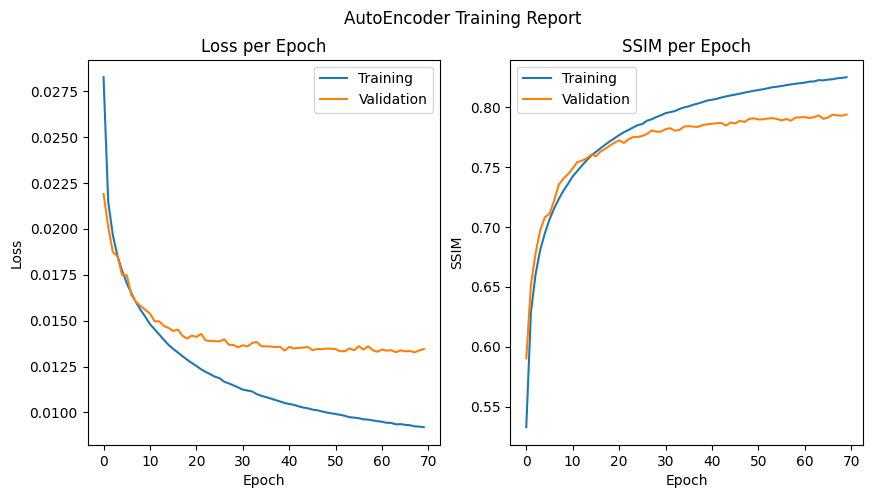

In [63]:
# Use this cell to:
# 1. Train the AutoEncoder model while bookkeeping the training and validation losses and SSIM scores for each epoch
# 2. Save the model weights using AutoEncoder.save_model_weights method
# 3. Save the training report using AutoEncoder.save_training_report method


# YOUR CODE HERE
def train_ae(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    MSE = torch.nn.MSELoss()

    train_losses = []
    val_losses = []
    train_ssim_scores = []
    val_ssim_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predicted_images = []
        train_true_images = []

        for augmented_images, clean_images, _ in train_loader:
            augmented_images = augmented_images.to(device)
            clean_images = clean_images.to(device)

            optimizer.zero_grad()


            outputs = model(augmented_images)
            loss = MSE(outputs, clean_images)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * augmented_images.size(0)

            train_predicted_images.extend(outputs.cpu().detach().numpy().reshape(-1, 28, 28))
            train_true_images.extend(clean_images.cpu().detach().numpy().reshape(-1, 28, 28))

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        train_ssim = get_ssim(train_predicted_images, train_true_images)
        train_ssim_scores.append(train_ssim)

        model.eval()
        val_loss = 0.0
        val_predicted_images = []
        val_true_images = []

        with torch.no_grad():
            for augmented_images, clean_images, _ in val_loader:
                augmented_images = augmented_images.to(device)
                clean_images = clean_images.to(device)

                outputs = model(augmented_images)
                loss = MSE(outputs, clean_images)

                val_loss += loss.item() * augmented_images.size(0)

                val_predicted_images.extend(outputs.cpu().detach().numpy().reshape(-1, 28, 28))
                val_true_images.extend(clean_images.cpu().detach().numpy().reshape(-1, 28, 28))

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        val_ssim = get_ssim(val_predicted_images, val_true_images)
        val_ssim_scores.append(val_ssim)

        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        print(f"Training SSIM: {train_ssim:.4f}, Validation SSIM: {val_ssim:.4f}")

    model.save_model_weights()
    model.save_training_report(train_losses, val_losses, train_ssim_scores, val_ssim_scores)

path_to_train_images_aug_dir = str(PATH_TO_TRAIN_DATA_DIR + "/aug")
path_to_train_images_clean_dir = str(PATH_TO_TRAIN_DATA_DIR + "/clean")
train_fashion_mnist_dataset = FashionMNISTDataset(
    path_to_augmented_images_dir=path_to_train_images_aug_dir,
    path_to_clean_images_dir=path_to_train_images_clean_dir,
)

path_to_test_images_aug_dir = str(PATH_TO_TEST_DATA_DIR + "/aug")
path_to_test_images_clean_dir = str(PATH_TO_TEST_DATA_DIR + "/clean")
val_fashion_mnist_dataset = FashionMNISTDataset(
    path_to_augmented_images_dir=path_to_test_images_aug_dir,
    path_to_clean_images_dir=path_to_test_images_clean_dir,
)


random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_fashion_mnist_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_fashion_mnist_dataset, batch_size=batch_size, shuffle=False)

latent_dim = 100
autoencoder = AutoEncoder(latent_dim)
print(f"Total number of trainable parameters: {autoencoder.count_parameters()}")
train_ae(autoencoder, train_loader, val_loader, num_epochs=70, lr=0.0008)

In [15]:
# tests for q3b

# `q4`: Variational AutoEncoder Model
* `q4a`: `VariationalAutoEncoder` class: Implement a VariationalAutoEncoder that uses the Encoder and Decoder Modules implemented in `q2a` and `q2b`. Constraints:
  1. The number of parameters in the VariationalAutoEncoder must be between 4,000 and 2,000,000 (both inclusive).
  2. The input tensor will be of shape `[batch_size, 1, 28, 28]` that comes out of the DataLoader of the `FashionMNIST` dataset.
  3. The output tensor must be of shape `[batch_size, 1, 28, 28]`. This tensor will be the reconstructed image of the input tensor.

* `q4b`: Training the models: Implement the training loop for the VariationalAutoEncoder model. Constraints:
  1. Use the `FashionMNIST` dataset implemented in `q1` to load the data.
  2. Use the `VariationalAutoEncoder` model implemented in `q4a`.
  3. You are free to choose any loss function, optimizer, and hyperparameters.
  4. **You must**:
     1. Book-keep the training and validation losses and SSIM scores for each epoch and use it to plot the training curves with the `VariationalAutoEncoder.save_training_report` method.
     2. To calculate the SSIM score, you can use the `get_ssim` function provided below.
     3. Save the model weights using `VariationalAutoEncoder.save_model_weights` method.


`q4` Grading [Total: 1.5 points]:
1. `q4a`: `VariationalAutoEncoder` class: `0.5` points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
2. `q4b`: Training the models: `1` points. You will be awarded points based on the SSIM score of the `VariationalAutoEncoder` model on a **hidden test set**. The grading will be as follows:
   1. 0.8 or more: `1` point
   2. 0.7 or more: `0.8` points
   3. 0.6 or more: `0.6` points
   4. 0.5 or more: `0.4` points
   5. 0.4 or more: `0.2` points
   6. Less than 0.4: `0` points

You are provided with the following template. **Populate only the sections marked as `# YOUR CODE HERE`. Do not modify other parts of the template.**

## `q4a`: `VariationalAutoEncoder` class

In [148]:
class VariationalAutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim: int):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = Encoder(output_channels=latent_dim * 2, type_of_autoencoder="vae")
        self.decoder = Decoder(input_channels=latent_dim, type_of_autoencoder="vae")
        self.latent_dim = latent_dim

    def reparameterize(self, mu, log_var):
        # YOUR CODE HERE
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)

        return mu + eps * std

    def forward(self, input_tensor):
        # YOUR CODE HERE
        latent_params, skip_connections = self.encoder(input_tensor)
        mu, log_var = torch.chunk(latent_params, 2, dim=1)

        z = self.reparameterize(mu, log_var)

        reconstructed = self.decoder(z, skip_connections = skip_connections)

        return reconstructed, mu, log_var 

    def loss_function(self, predicted_images, gt_images, mu, log_var):
        MSE = torch.nn.MSELoss(reduction='sum')
        mse_loss = MSE(predicted_images, gt_images)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        total_loss = mse_loss + kl_divergence
        return total_loss, mse_loss, kl_divergence

    def save_model_weights(self):
        torch.save(self.state_dict(), "variational_auto_encoder.pth")

    def load_model_weights(self):
        self.load_state_dict(torch.load("variational_auto_encoder.pth"))

    def save_training_report(
        self,
        list_of_train_losses: List[float],
        list_of_val_losses: List[float],
        list_of_train_ssim_scores: List[float],
        list_of_val_ssim_scores: List[float],
    ):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Loss per Epoch")
        plt.plot(list_of_train_losses, label="Training")
        plt.plot(list_of_val_losses, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("SSIM per Epoch")
        plt.plot(list_of_train_ssim_scores, label="Training")
        plt.plot(list_of_val_ssim_scores, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.legend()

        plt.suptitle("VariationalAutoEncoder Training Report")

        plt.savefig("variational_auto_encoder.png")
        plt.show()

    
    # def count_parameters(self):
    #     return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [17]:
# tests for q4a

variational_autoencoder = VariationalAutoEncoder(latent_dim=64)

random_input_tensor = torch.randn(1, 1, 28, 28)
output = variational_autoencoder(random_input_tensor)


del variational_autoencoder

## `q4b`: Training the model

Total number of trainable parameters: 1973537


Epoch [1/50]
Training Loss: 2092.3698, Validation Loss: 1693.5216
Training SSIM: 0.4276, Validation SSIM: 0.5028
Epoch [2/50]
Training Loss: 1524.1351, Validation Loss: 1381.1847
Training SSIM: 0.5284, Validation SSIM: 0.5912
Epoch [3/50]
Training Loss: 1365.1917, Validation Loss: 1306.8608
Training SSIM: 0.5715, Validation SSIM: 0.5879
Epoch [4/50]
Training Loss: 1285.9925, Validation Loss: 1229.7983
Training SSIM: 0.5928, Validation SSIM: 0.6032
Epoch [5/50]
Training Loss: 1230.0377, Validation Loss: 1168.7602
Training SSIM: 0.6075, Validation SSIM: 0.6250
Epoch [6/50]
Training Loss: 1189.5528, Validation Loss: 1172.8191
Training SSIM: 0.6191, Validation SSIM: 0.6323
Epoch [7/50]
Training Loss: 1151.2855, Validation Loss: 1105.0437
Training SSIM: 0.6290, Validation SSIM: 0.6421
Epoch [8/50]
Training Loss: 1127.7393, Validation Loss: 1092.2314
Training SSIM: 0.6353, Validation SSIM: 0.6542
Epoch [9/50]
Training Loss: 1103.2685, Validation Loss: 1068.7094
Training SSIM: 0.6419, Validat

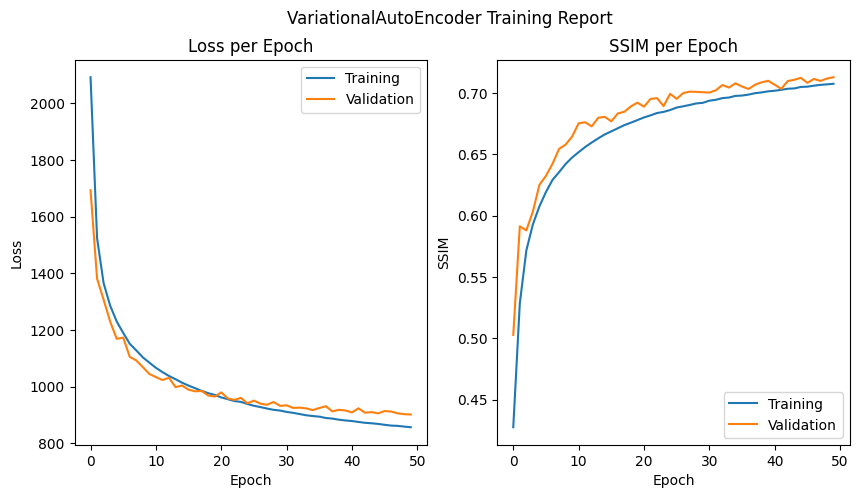

In [151]:
# Use this cell to:
# 1. Train the VariationalAutoEncoder model while bookkeeping the training and validation losses and SSIM scores for each epoch
# 2. Save the model weights using VariationalAutoEncoder.save_model_weights method
# 3. Save the training report using VariationalAutoEncoder.save_training_report method

def train_vae(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    train_ssim_scores = []
    val_ssim_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predicted_images = []
        train_true_images = []
        
        for augmented_images, clean_images, _ in train_loader:
            augmented_images = augmented_images.to(device)
            clean_images = clean_images.to(device)
            
            reconstructed, mu, log_var = model(augmented_images)
            loss, recon_loss, kl_loss = model.loss_function(reconstructed, clean_images, mu, log_var)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * augmented_images.size(0)
            train_predicted_images.extend(reconstructed.cpu().detach().numpy().reshape(-1, 28, 28))
            train_true_images.extend(clean_images.cpu().detach().numpy().reshape(-1, 28, 28))
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_ssim = get_ssim(train_predicted_images, train_true_images)
        train_ssim_scores.append(train_ssim)
        
        model.eval()
        val_loss = 0.0
        val_predicted_images = []
        val_true_images = []
        
        with torch.no_grad():
            for augmented_images, clean_images, _ in val_loader:
                augmented_images = augmented_images.to(device)
                clean_images = clean_images.to(device)
                
                reconstructed, mu, log_var = model(augmented_images)
                loss, _, _ = model.loss_function(reconstructed, clean_images, mu, log_var)
                
                val_loss += loss.item() * augmented_images.size(0)
                val_predicted_images.extend(reconstructed.cpu().detach().numpy().reshape(-1, 28, 28))
                val_true_images.extend(clean_images.cpu().detach().numpy().reshape(-1, 28, 28))
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_ssim = get_ssim(val_predicted_images, val_true_images)
        val_ssim_scores.append(val_ssim)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        print(f"Training SSIM: {train_ssim:.4f}, Validation SSIM: {val_ssim:.4f}")
    
    model.save_model_weights()
    model.save_training_report(train_losses, val_losses, train_ssim_scores, val_ssim_scores)

random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_fashion_mnist_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_fashion_mnist_dataset, batch_size=batch_size, shuffle=False)

latent_dim = 64
autoencoder = VariationalAutoEncoder(latent_dim)
print(f"Total number of trainable parameters: {autoencoder.count_parameters()}")
train_vae(autoencoder, train_loader, val_loader, num_epochs=50, lr=0.001)

In [ ]:
# tests for q4b

# `q5`: Conditional Variational AutoEncoder Model
* `q5a`: `ConditionalVariationalAutoEncoder` class: Implement a ConditionalVariationalAutoEncoder that uses the Encoder and Decoder Modules implemented in `q2a` and `q2b`. Constraints:
  1. The number of parameters in the ConditionalVariationalAutoEncoder must be between 4,000 and 2,000,000 (both inclusive).
  2. The input tensor will be of shape `[batch_size, 1, 28, 28]` that comes out of the DataLoader of the `FashionMNIST` dataset.
  3. The output tensor must be of shape `[batch_size, 1, 28, 28]`. This tensor will be the reconstructed image of the input tensor.

* `q5b`: Training the models: Implement the training loop for the ConditionalVariationalAutoEncoder model. Constraints:
  1. Use the `FashionMNIST` dataset implemented in `q1` to load the data.
  2. Use the `ConditionalVariationalAutoEncoder` model implemented in `q5a`.
  3. You are free to choose any loss function, optimizer, and hyperparameters.
  4. **You must**:
     1. Book-keep the training and validation losses and SSIM scores for each epoch and use it to plot the training curves with the `ConditionalVariationalAutoEncoder.save_training_report` method.
     2. To calculate the SSIM score, you can use the `get_ssim` function provided below.
     3. Save the model weights using `ConditionalVariationalAutoEncoder.save_model_weights` method.


`q5` Grading [Total: 1.5 points]:
1. `q5a`: `ConditionalVariationalAutoEncoder` class: `0.5` points if the code runs without any errors on hidden test cases, otherwise 0 points. No partial points for this question.
2. `q5b`: Training the models: `1` points. You will be awarded points based on the SSIM score of the `ConditionalVariationalAutoEncoder` model on a **hidden test set**. The grading will be as follows:
   1. 0.8 or more: `1` point
   2. 0.7 or more: `0.8` points
   3. 0.6 or more: `0.6` points
   4. 0.5 or more: `0.4` points
   5. 0.4 or more: `0.2` points
   6. Less than 0.4: `0` points

You are provided with the following template. **Populate only the sections marked as `# YOUR CODE HERE`. Do not modify other parts of the template.**

## `q5a`: `ConditionalVariationalAutoEncoder`

In [142]:
class ConditionalVariationalAutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim: int, condition_dim: int):
        super(ConditionalVariationalAutoEncoder, self).__init__()
        self.encoder = Encoder(output_channels=latent_dim * 2, type_of_autoencoder="cvae")
        self.decoder = Decoder(input_channels=latent_dim, type_of_autoencoder="cvae")
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        
        self.condition_encoder = torch.nn.Sequential(
            torch.nn.Linear(condition_dim, 128),
            torch.nn.SiLU(),
            torch.nn.Linear(128, 28*28),
            torch.nn.SiLU()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, input_tensor, condition_tensor):
        processed_condition = self.condition_encoder(condition_tensor)
        processed_condition = processed_condition.view(-1, 1, 28, 28)
        
        combined_input = input_tensor + processed_condition
        
        latent_params, skip_connections = self.encoder(combined_input)
        mu, log_var = torch.chunk(latent_params, 2, dim=1)
        
        z = self.reparameterize(mu, log_var)
        
        reconstructed = self.decoder(z, condition=processed_condition, skip_connections=skip_connections)
        
        return reconstructed, mu, log_var

    def loss_function(self, predicted_images, gt_images, mu, log_var):
        MSE = torch.nn.MSELoss(reduction='sum')
        reconstruction_loss = MSE(predicted_images, gt_images)
        
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        total_loss = reconstruction_loss + kl_loss
        return total_loss, reconstruction_loss, kl_loss

    def save_model_weights(self):
        torch.save(self.state_dict(), "conditional_variational_auto_encoder.pth")

    def load_model_weights(self):
        self.load_state_dict(torch.load("conditional_variational_auto_encoder.pth"))

    def save_training_report(
        self,
        list_of_train_losses: List[float],
        list_of_val_losses: List[float],
        list_of_train_ssim_scores: List[float],
        list_of_val_ssim_scores: List[float],
    ):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title("Loss per Epoch")
        plt.plot(list_of_train_losses, label="Training")
        plt.plot(list_of_val_losses, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.title("SSIM per Epoch")
        plt.plot(list_of_train_ssim_scores, label="Training")
        plt.plot(list_of_val_ssim_scores, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.legend()

        plt.suptitle("ConditionalVariationalAutoEncoder Training Report")

        plt.savefig("conditional_variational_auto_encoder.png")
        plt.show()

In [68]:
# tests for q5a

conditional_variational_autoencoder = ConditionalVariationalAutoEncoder(
    latent_dim=64, condition_dim=10
)

random_input_tensor = torch.randn(1, 1, 28, 28)
random_condition_tensor = torch.randn(1, 10)
output = conditional_variational_autoencoder(
    random_input_tensor, random_condition_tensor
)


del conditional_variational_autoencoder

## `q5b`: Training the model

Total number of trainable parameters: 1943825


Epoch [1/40]
Training Loss: 1824.3919, Validation Loss: 1476.1638
Training SSIM: 0.4525, Validation SSIM: 0.5299
Epoch [2/40]
Training Loss: 1420.0377, Validation Loss: 1326.9682
Training SSIM: 0.5480, Validation SSIM: 0.5743
Epoch [3/40]
Training Loss: 1309.1858, Validation Loss: 1233.2091
Training SSIM: 0.5819, Validation SSIM: 0.5945
Epoch [4/40]
Training Loss: 1241.1001, Validation Loss: 1174.2362
Training SSIM: 0.6013, Validation SSIM: 0.6290
Epoch [5/40]
Training Loss: 1189.7468, Validation Loss: 1121.1747
Training SSIM: 0.6161, Validation SSIM: 0.6357
Epoch [6/40]
Training Loss: 1149.3528, Validation Loss: 1109.2648
Training SSIM: 0.6279, Validation SSIM: 0.6405
Epoch [7/40]
Training Loss: 1120.3002, Validation Loss: 1080.5223
Training SSIM: 0.6369, Validation SSIM: 0.6550
Epoch [8/40]
Training Loss: 1095.7118, Validation Loss: 1095.7649
Training SSIM: 0.6440, Validation SSIM: 0.6576
Epoch [9/40]
Training Loss: 1075.2070, Validation Loss: 1039.0156
Training SSIM: 0.6498, Validat

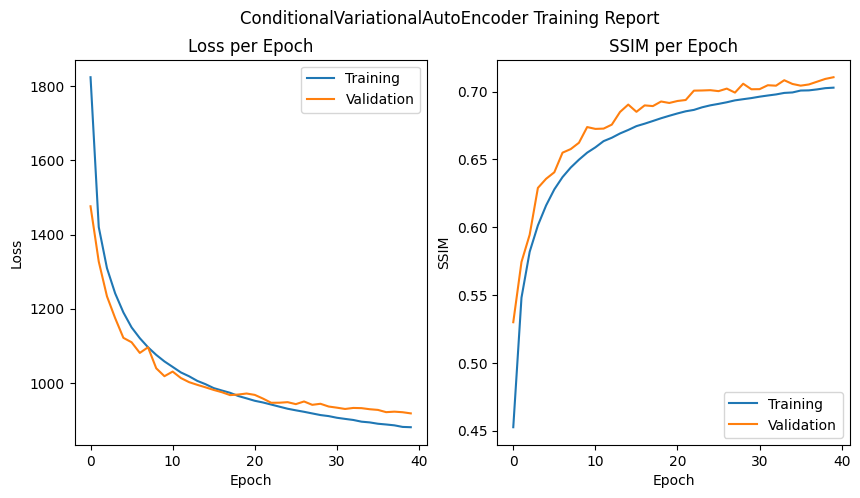

In [146]:
# Use this cell to:
# 1. Train the ConditionalVariationalAutoEncoder model while bookkeeping the training and validation losses and SSIM scores for each epoch
# 2. Save the model weights using ConditionalVariationalAutoEncoder.save_model_weights method
# 3. Save the training report using ConditionalVariationalAutoEncoder.save_training_report method

def train_cvae(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    train_ssim_scores = []
    val_ssim_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_predicted_images = []
        train_true_images = []
        
        for augmented_images, clean_images, labels in train_loader:
            augmented_images = augmented_images.to(device)
            clean_images = clean_images.to(device)
            
            condition = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
            
            optimizer.zero_grad()
            reconstructed, mu, log_var = model(augmented_images, condition)
            loss, recon_loss, kl_loss = model.loss_function(reconstructed, clean_images, mu, log_var)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * augmented_images.size(0)
            train_predicted_images.extend(reconstructed.cpu().detach().numpy().reshape(-1, 28, 28))
            train_true_images.extend(clean_images.cpu().detach().numpy().reshape(-1, 28, 28))
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_ssim = get_ssim(train_predicted_images, train_true_images)
        train_ssim_scores.append(train_ssim)
        
        model.eval()
        val_loss = 0.0
        val_predicted_images = []
        val_true_images = []
        
        with torch.no_grad():
            for augmented_images, clean_images, labels in val_loader:
                augmented_images = augmented_images.to(device)
                clean_images = clean_images.to(device)
                condition = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
                
                reconstructed, mu, log_var = model(augmented_images, condition)
                loss, _, _ = model.loss_function(reconstructed, clean_images, mu, log_var)
                
                val_loss += loss.item() * augmented_images.size(0)
                val_predicted_images.extend(reconstructed.cpu().detach().numpy().reshape(-1, 28, 28))
                val_true_images.extend(clean_images.cpu().detach().numpy().reshape(-1, 28, 28))
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        val_ssim = get_ssim(val_predicted_images, val_true_images)
        val_ssim_scores.append(val_ssim)
        
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
        print(f"Training SSIM: {train_ssim:.4f}, Validation SSIM: {val_ssim:.4f}")
    
    model.save_model_weights()
    model.save_training_report(train_losses, val_losses, train_ssim_scores, val_ssim_scores)

random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_fashion_mnist_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_fashion_mnist_dataset, batch_size=batch_size, shuffle=False)

latent_dim = 56
condition_dim = 10
cvae = ConditionalVariationalAutoEncoder(latent_dim=latent_dim, condition_dim=condition_dim)
print(f"Total number of trainable parameters: {sum(p.numel() for p in cvae.parameters() if p.requires_grad)}")
train_cvae(cvae, train_loader, val_loader, num_epochs=40, lr=0.001)

In [ ]:
# tests for q5b

In [ ]:
# tests for q3b, q4b, q5b

